In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, \
    auc, mean_absolute_error
from gensim.models import KeyedVectors
from sklearn.dummy import DummyClassifier

from nltk.corpus import stopwords
import nltk

from nlp_tweets.preprocess import clean_text, get_sequences, get_embedding_matrix
from nlp_tweets.model import get_model
from nlp_tweets.eda import plot_roc_curve_mean, get_categorial_confusion_matrix

In [15]:
PATH_RAW = '../data/raw/'
PATH_PROCESSED = '../data/processed/'

TRAIN_COLUMNS = ['id', 'text', 'target']
TEST_COLUMNS = ['id', 'text']
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 50

# Loading

In [16]:
tweets_df = pd.read_csv(PATH_RAW + 'train.csv')
tweets_df = tweets_df[TRAIN_COLUMNS]
tweets_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
tweets_test_df = pd.read_csv(PATH_RAW + 'test.csv')
tweets_test_df = tweets_test_df[TEST_COLUMNS]

# Preprocessing

In [18]:
to_remove_caracters = ['/', '-', '[', ']', ',', ':', '&', '>', '<', '\\', '#']

stops = list(stopwords.words("english")) + list(stopwords.words("french"))
stops = [unidecode.unidecode(stop_words) for stop_words in stops]
stop_words = ['']
stop_words += stops

In [19]:
tweets_df['text']      = tweets_df['text'].apply(clean_text(to_remove_caracters, 
                                                       stop_words))
tweets_test_df['text'] = tweets_test_df['text'].apply(clean_text(to_remove_caracters, 
                                                       stop_words))

In [20]:
data, tokenizer = get_sequences(vocabulary_size=MAX_NB_WORDS, maxlen=MAX_SEQUENCE_LENGTH, texts=tweets_df['text'])

In [21]:
test_data, _ = get_sequences(vocabulary_size=MAX_NB_WORDS, maxlen=MAX_SEQUENCE_LENGTH, 
                          texts=tweets_test_df['text'], tokenizer=tokenizer)

In [22]:
pretrained_embeddings_path = PATH_RAW + "GoogleNews-vectors-negative300.bin"
word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

In [23]:
embedding_matrix = get_embedding_matrix(tokenizer=tokenizer, 
                                        word2vec=word2vec, 
                                        max_nb_words=MAX_NB_WORDS, 
                                        enbedding_dim=EMBEDDING_DIM)

# Train test split

In [24]:
X_train, X_val, y_train, y_val = train_test_split(data, tweets_df['target'], test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val)

print(X_train.shape, X_val.shape, X_test.shape)

(4567, 50) (2284, 50) (762, 50)


# Create Model

## Baseline

In [25]:
baseline_model = DummyClassifier(strategy="most_frequent")

### Train

In [26]:
baseline_model.fit(X_train,y_train)

DummyClassifier(strategy='most_frequent')

### Test

In [27]:
baseline_pre_on_test = baseline_model.predict(X_test)

In [28]:
baseline_mae = mean_absolute_error(y_test, baseline_pre_on_test)
print(f'The mae for the baseline on test set is {baseline_mae}')

The mae for the baseline on test set is 0.4094488188976378


array([[450.],
       [312.]])

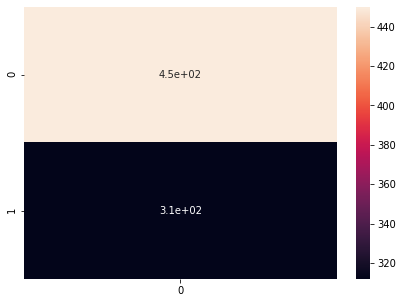

In [29]:
get_categorial_confusion_matrix(y_test, baseline_pre_on_test, display=True)

## GRU model

In [30]:
model = get_model(vocabulary_size=MAX_NB_WORDS, embeding_dim=EMBEDDING_DIM, 
                  max_sequence_length=MAX_SEQUENCE_LENGTH,_rnn_nb=[128, 64, 32], _fc_nb=[32, 16], dropout_rate=0.5) 
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           6000000   
_________________________________________________________________
gru (GRU)                    (None, 50, 128)           165120    
_________________________________________________________________
gru_1 (GRU)                  (None, 50, 64)            37248     
_________________________________________________________________
gru_2 (GRU)                  (None, 50, 32)            9408      
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 32)            1056      
_________________________________________________________________
dropout (Dropout)            (None, 50, 32)           

### Train

In [31]:
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
)

Epoch 1/100
72/72 [==============================] - 12s 163ms/step - loss: 0.8784 - accuracy: 0.4979 - val_loss: 0.8330 - val_accuracy: 0.5679
Epoch 2/100
72/72 [==============================] - 10s 138ms/step - loss: 0.8121 - accuracy: 0.5049 - val_loss: 0.7159 - val_accuracy: 0.5679
Epoch 3/100
72/72 [==============================] - 10s 145ms/step - loss: 0.7533 - accuracy: 0.5268 - val_loss: 0.6861 - val_accuracy: 0.5679
Epoch 4/100
72/72 [==============================] - 10s 139ms/step - loss: 0.7471 - accuracy: 0.5295 - val_loss: 0.6909 - val_accuracy: 0.5311
Epoch 5/100
72/72 [==============================] - 10s 143ms/step - loss: 0.7345 - accuracy: 0.5172 - val_loss: 0.6799 - val_accuracy: 0.5775
Epoch 6/100
72/72 [==============================] - 10s 142ms/step - loss: 0.7235 - accuracy: 0.5224 - val_loss: 0.6803 - val_accuracy: 0.5679
Epoch 7/100
72/72 [==============================] - 10s 140ms/step - loss: 0.7140 - accuracy: 0.5334 - val_loss: 0.6779 - val_accuracy:

Epoch 58/100
72/72 [==============================] - 10s 133ms/step - loss: 0.5738 - accuracy: 0.7243 - val_loss: 0.5928 - val_accuracy: 0.6961
Epoch 59/100
72/72 [==============================] - 10s 134ms/step - loss: 0.5833 - accuracy: 0.7160 - val_loss: 0.6123 - val_accuracy: 0.7001
Epoch 60/100
72/72 [==============================] - 10s 132ms/step - loss: 0.5808 - accuracy: 0.7182 - val_loss: 0.6166 - val_accuracy: 0.6778
Epoch 61/100
72/72 [==============================] - 11s 146ms/step - loss: 0.5769 - accuracy: 0.7182 - val_loss: 0.5987 - val_accuracy: 0.7123
Epoch 62/100
72/72 [==============================] - 10s 134ms/step - loss: 0.5719 - accuracy: 0.7274 - val_loss: 0.5832 - val_accuracy: 0.7088
Epoch 63/100
72/72 [==============================] - 10s 132ms/step - loss: 0.5757 - accuracy: 0.7182 - val_loss: 0.5865 - val_accuracy: 0.6975
Epoch 64/100
72/72 [==============================] - 10s 136ms/step - loss: 0.5818 - accuracy: 0.7083 - val_loss: 0.5771 - val_ac

### Finding the best threshold

In [32]:
pred_proba_train = model.predict(X_train)
pred_proba_val = model.predict(X_val)

Train Accuracy: 0.8202320998467265 
Train Confusion Matrix:
[[2448  147]
 [ 674 1298]]
Test Accuracy: 0.718476357267951 
Test Confusion Matrix:
[[1111  186]
 [ 457  530]]


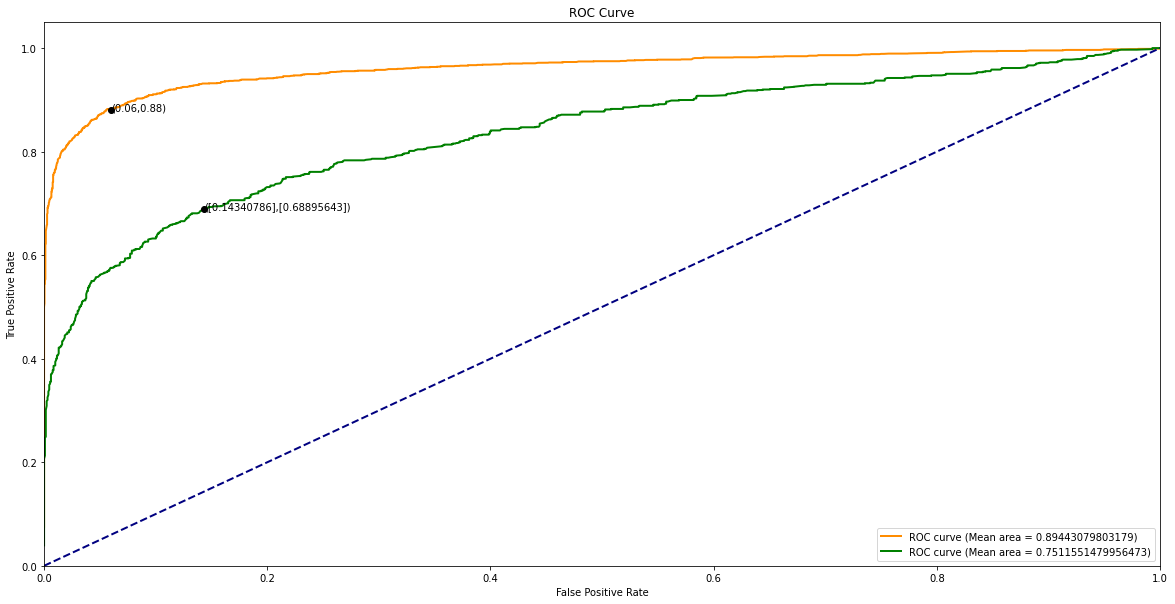

In [33]:
threshold = plot_roc_curve_mean(y_train=y_train.values, y_train_pred_proba=pred_proba_train, 
                        y_test=y_val.values, y_test_pred_proba=pred_proba_val)

### Test

In [34]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 0s 20ms/step - loss: 0.5968 - accuracy: 0.7047


[0.5967987775802612, 0.7047244310379028]

In [35]:
pred_proba_test = model.predict(X_test).reshape(-1)
pred_proba_test = (pred_proba_test > threshold).astype(int)

array([[391.,  59.],
       [162., 150.]])

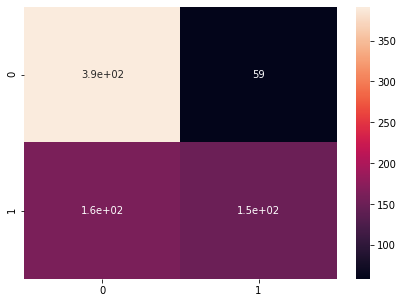

In [36]:
get_categorial_confusion_matrix(y_test, pred_proba_test, display=True)

# Predict

In [37]:
predictions = model.predict(test_data)
predictions = (predictions > threshold).astype(int)

In [38]:
output = pd.read_csv(PATH_RAW + 'sample_submission.csv')
output['target'] = predictions
output.to_csv(PATH_PROCESSED + 'to_submit.csv', index=False)